In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt


In [37]:
# Load data
df = pd.read_parquet('snotel_data.parquet')
df.head()

,date,snow_depth,red,green,blue,coastal,nir08,swir16,swir22,fsca,item_id,station_triplet,latitude,longitude,elevation
0,2025-05-10T18:49:15.298686Z,87,23783,24067,24563,24717.0,24915,16878,17017,539.0,LC08_CU_004002_20250510_20250518_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0
1,2025-05-26T18:49:08.643245Z,64,30420,30484,31724,31765.0,30553,22723,18696,531.0,LC08_CU_004002_20250526_20250606_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0
2,2025-04-24T18:49:03.983677Z,121,20230,20543,20727,19248.0,21290,8042,7762,742.0,LC08_CU_004002_20250424_20250503_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0
3,2025-05-01T18:55:04.333565Z,109,20102,19735,20009,18958.0,20637,7832,7657,1925.0,LC08_CU_004002_20250501_20250511_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0
4,2025-05-18T18:49:11.983471Z,79,24109,23672,24416,23895.0,27251,12570,12144,NaN,LC09_CU_004002_20250518_20250721_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0


In [29]:
stations = df.station_triplet.unique()

In [30]:
snotel_stations = pd.read_json("snotel-wa-stations.json")

In [31]:
for station in stations:
    station_lat, station_lon = snotel_stations[snotel_stations.stationTriplet == station].latitude.values[0], snotel_stations[snotel_stations.stationTriplet == station].longitude.values[0]
    df.loc[df['station_triplet'] == station, 'latitude'] = station_lat
    df.loc[df['station_triplet'] == station, 'longitude'] = station_lon
    df.loc[df['station_triplet'] == station, 'elevation'] = snotel_stations[snotel_stations.stationTriplet == station].elevation.values[0]

<Axes: >

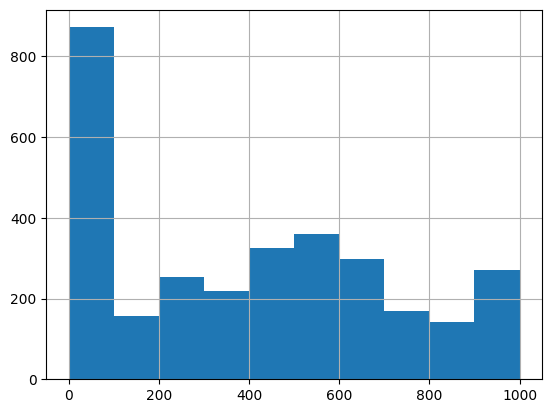

In [74]:
df.loc[~df['fsca'].between(0, 1000), 'fsca'] = None
df.fsca.hist()

In [76]:

# Load input and output columns from data frame
input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca"]
input_data = df[input_columns].values
output_columns = ['snow_depth']
output_data = df[output_columns].values


In [77]:
# Scale data
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(input_data).astype(np.float32)
Y_scaler = MinMaxScaler()
Y_scaled = Y_scaler.fit_transform(output_data).astype(np.float32)

In [78]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.33, random_state=42)


# Train models

## Linear model



In [18]:
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)
# linear_y_pred = linear_model.predict(X_test)
# linear_pearsonr = pearsonr(linear_y_pred, y_test)
# linear_pearsonr

## Random Forest model

In [82]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
random_forest_y_pred = rf_model.predict(X_test)
random_forest_pearsonr = pearsonr(random_forest_y_pred, y_test[:,0])
random_forest_pearsonr

/usr/local/lib64/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


PearsonRResult(statistic=np.float64(0.5767650408894103), pvalue=np.float64(1.4639045252656596e-133))

Text(0, 0.5, 'predicted snow depth')

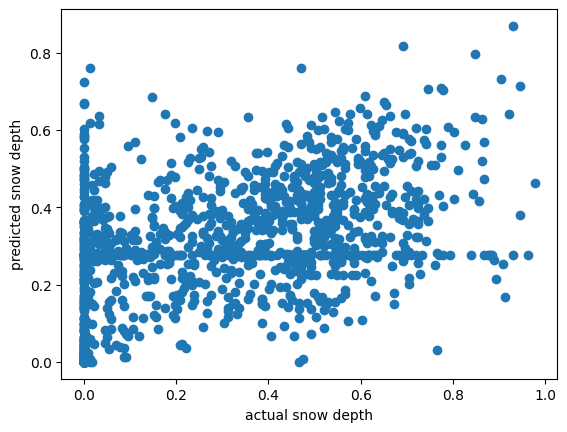

In [80]:
plt.scatter(y_test[:,0], random_forest_y_pred)
plt.xlabel("actual snow depth")
plt.ylabel("predicted snow depth")

In [10]:
# Save models and scalers
import joblib

# Save individual models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(X_scaler, 'X_scaler.pkl')
joblib.dump(Y_scaler, 'Y_scaler.pkl')

print("Models and scalers saved successfully!")


Models and scalers saved successfully!
